In [2]:
<a href="https://colab.research.google.com/github/hbretonniere/ucsc_ml_intro/blob/master/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SyntaxError: invalid syntax (1158592660.py, line 1)

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import trange
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.python import debug as tf_debug
tfd = tfp.distributions
tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [35]:
tf.__version__

'2.13.0'

In [36]:

tfp.__version__

'0.20.1'

In [37]:
def encoder(latent_dim):

    encoder_input = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(8, (3,3), 2, 'SAME', activation='relu')(encoder_input)
    x = layers.Conv2D(16, (3,3), 2, 'SAME', activation='relu')(x)
    # x = layers.Conv2D(64, (3,3), 2, 'SAME', activation='relu')(x)
    x = layers.Flatten()(x)
    # x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(2*latent_dim)(x)

    encoder_output = x
    Encoder = keras.Model(encoder_input, encoder_output, name='encoder_VAE_MNIST')
    return Encoder, encoder_output


In [38]:
latent_dim = 8

In [39]:
Encoder, encoder_output = encoder(latent_dim)
Encoder.summary()

Model: "encoder_VAE_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
Total params: 13808 (53.94 KB)
Trainable params: 13808 (53.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
def decoder(encoder_output, latent_dim):

    decoder_input = keras.Input(shape=encoder_output.shape[1:]) #ignore batch size
    print(decoder_input)
    x = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:\
             tfd.MultivariateNormalDiag(loc=t[..., :latent_dim], scale_diag=tf.exp(t[..., latent_dim:])),
             convert_to_tensor_fn=lambda s: s.sample())(decoder_input)

    z_mean = decoder_input[..., :latent_dim]
    z_log_var = decoder_input[..., latent_dim:]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # reparametrization trick
    x = z_mean + tf.exp(0.5 * z_log_var) * epsilon


    x = layers.Dense(7 * 7 * 64, activation='relu')(x)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
#     out_2 = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
    decoder_output = x
    Decoder = keras.Model(inputs=decoder_input, outputs=x, name='decoder_VAE_MNIST')
    return Decoder

In [41]:
Decoder = decoder(encoder_output, latent_dim)
Decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Model: "decoder_VAE_MNIST"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 8)                    0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 8)                    0         ['input_2[0][0]']             
  (SlicingOpLambda)                  

In [42]:
VAE_input = keras.Input(shape=(28, 28, 1))

encoded_img = Encoder(VAE_input)

decoded_img = Decoder(encoded_img)

VAE_output = [decoded_img, encoded_img]

model = keras.Model(inputs=VAE_input, outputs=VAE_output, name='mnist_vae')
model.summary()

Model: "mnist_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder_VAE_MNIST (Functio  (None, 16)                13808     
 nal)                                                            
                                                                 
 decoder_VAE_MNIST (Functio  (None, 28, 28, 1)         51457     
 nal)                                                            
                                                                 
Total params: 65265 (254.94 KB)
Trainable params: 65265 (254.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)


In [44]:
def loss_fn(y_true, y_predict):

    reconstruct = y_predict[0]
    rec_loss_batch = tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, reconstruct), axis=[1, 2])
    rec_loss = tf.reduce_mean(rec_loss_batch)

    z_mean, z_sigma = y_predict[1][:, :latent_dim], y_predict[1][:, latent_dim:]
    kl_loss_batch = -0.5 * tf.reduce_sum(z_sigma - tf.square(z_mean) - tf.exp(z_sigma) + 1, axis=1)
    kl_loss = tf.reduce_mean(kl_loss_batch)
    loss = rec_loss + kl_loss

    return loss, rec_loss, kl_loss


test_train = []


@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        prediction = model(x)
        tot_loss, rec_loss, kl_loss = loss_fn(x, prediction)

        grads = tape.gradient(tot_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return tot_loss, rec_loss, kl_loss


In [45]:
tot_loss_results = []
rec_loss_results = []
kl_loss_results = []

In [46]:
nb_epochs = 20
optimizer = keras.optimizers.Adam(learning_rate=0.005)

t = trange(nb_epochs, desc='Convo VAE')


''' Training Loop'''
for epoch in t:
    epoch_loss_avg = tf.keras.metrics.Mean()
    for i, features in enumerate(x_train):
        losses = train_step(features)
        tot_loss_results.append(losses[0])
        rec_loss_results.append(losses[1])
        kl_loss_results.append(losses[2])

    t.set_description('Conv VAE, loss=%g' % tot_loss_results[-1])


Conv VAE, loss=110.991: 100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


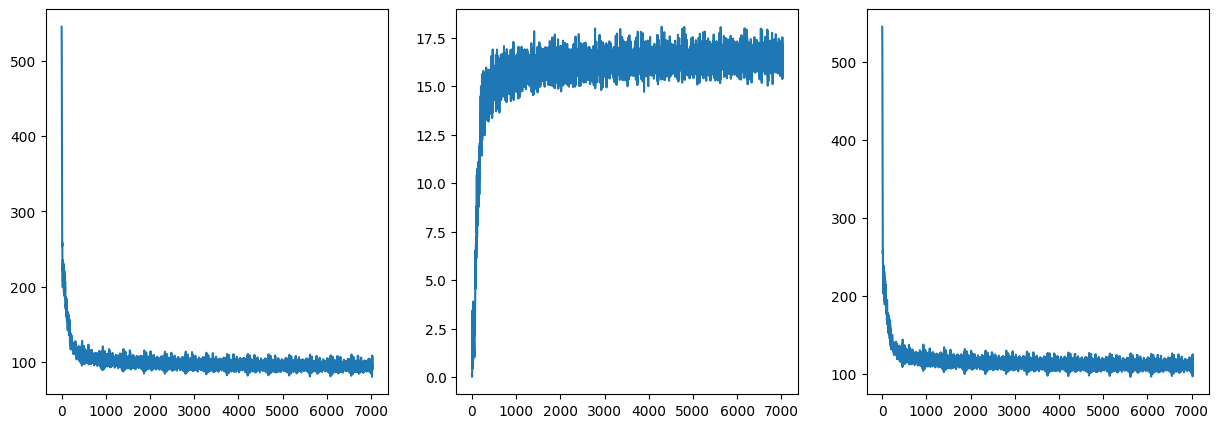

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.arange(len(rec_loss_results)), rec_loss_results)
ax[1].plot(np.arange(len(kl_loss_results)), kl_loss_results)
ax[2].plot(np.arange(len(tot_loss_results)), tot_loss_results)

ax[0].set_title('MSE')
ax[0].set_title('KL')
ax[0].set_title('Total_loss')


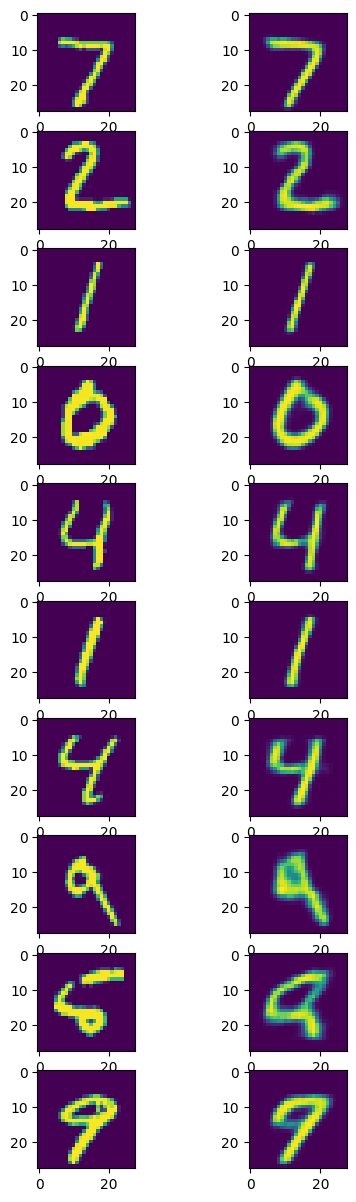

In [48]:
fig, ax = plt.subplots(10, 2, figsize=(5, 15))
for i in range(10):
    ax[i, 0].imshow(x_test[i])
    ax[i, 1].imshow(model(x_test[i:i+1])[0].numpy()[0, :, :, 0])